# Airbnb Fiyat Tahmini ML Algoritması

# Gerekli Kütüphaneler

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.cross_validation import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error 
import xgboost

ModuleNotFoundError: No module named 'sklearn.cross_validation'

# Veri Yükleme ve Veri Analizi

## Airbnb Liste Sayısı ve Ev Sayısı

In [2]:
ilan_df = pd.read_csv('listings.csv')
ilan_sayisi = ilan_df['id'].count()
ev_sayisi = len(ilan_df['host_id'].unique())
print('Veride bulunan liste sayısı: %d konaklanacak ev sayısı: %d' % (ilan_sayisi,ev_sayisi))

Veride bulunan liste sayısı: 3818 konaklanacak ev sayısı: 2751


# Kayıp Veri Analizi

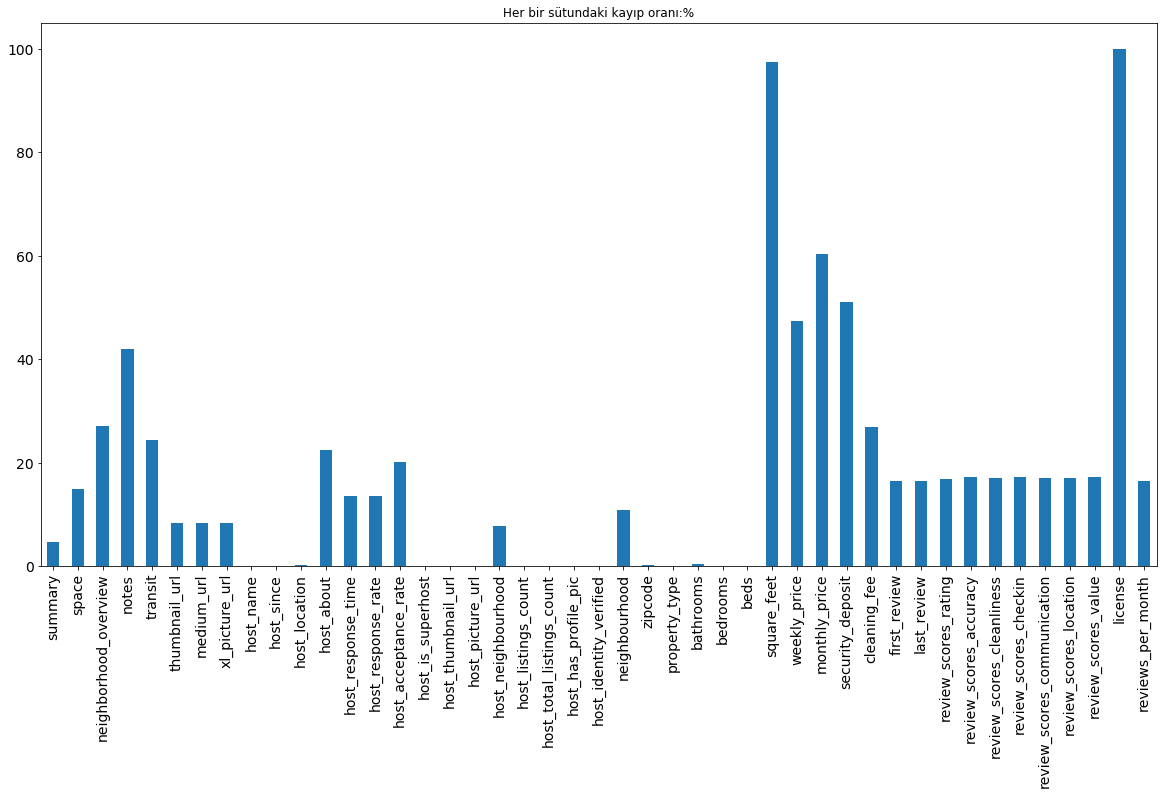

In [3]:
ilan_kayip_df = ilan_df.isnull().mean()*100
ilan_sutun_bos_sayisi = ilan_kayip_df[ilan_kayip_df > 0]
ilan_sutun_bos_sayisi.plot.bar(title='Her bir sütundaki kayıp oranı:%',fontsize=14,figsize=(20,10))

# Rezervasyon Bilgilerinin Yüklenme İşlemi

In [4]:
takvim_df = pd.read_csv('calendar.csv')
satir_sayisi = takvim_df.shape[0]
enkucuk_tarih = takvim_df['date'].min()
enbuyuk_tarih = takvim_df['date'].max()
print('Veride bulunan satır sayısı: %d' % (satir_sayisi))
print('İlk tarih: %s Son Tarih: %s.' % (enkucuk_tarih, enbuyuk_tarih))

Veride bulunan satır sayısı: 1393570
İlk tarih: 2016-01-04 Son Tarih: 2017-01-02.


## Kayıp Veri Analizi - Tavkim Veri Seti İçin

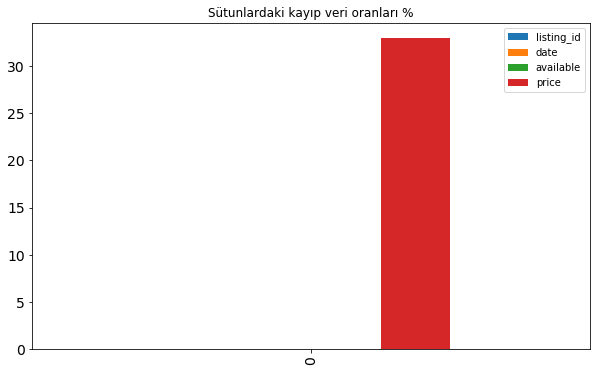

In [5]:
takvim_kayip_df = pd.DataFrame([takvim_df.isnull().mean()*100])
takvim_kayip_df.plot.bar(title='Sütunlardaki kayıp veri oranları %',fontsize=14,figsize=(10,6))

# Yardımcı Fonksiyonlar Veri Temizleme İşleminde Kullanılması

In [6]:
#Veri temizle için yardımcı fonksiyon
def get_month_from_date(row):
    ''' Ay bulma '''
    return int(row['date'].split('-')[1])

def get_year_from_date(row):
    ''' Yıl bulma '''
    return int(row['date'].split('-')[0])

def get_host_since_year(row):
    ''' konaklama yılını bulma '''
    try:
        host_since = int(row['host_since'].split('-')[0])
    except:
        host_since = np.nan
    return host_since

def get_val_from_list(row, column_name, value):
    ''' Kukla sütunları doldurma '''
    val = 0.0
    try:
        vals = row[column_name].replace('[',
                                        '').replace("'", '').replace("]", '').replace('"',
                                        '').replace('{', '').replace('}', '').split(',')
        if value in vals:
            val = 1.0
    except:
        val = 0.0
    return val

def split_list_into_columns(df, column_name, max_dummies_num = 10):
    ''' sütunda bulunan değerleri liste haline getirme örneğin: amenities/kolaylıklar '''
    
    # versetindeki tekil değerleri getirme
    values_dict = {}

    for unique_value in df[column_name].unique(): 
        for value in unique_value.replace('[', '').replace("'",
                                                           '').replace("]", '').replace('"', '').replace('{',
                                                            '').replace('}', '').split(','):
            if value in values_dict:
                values_dict[value] = values_dict[value] + 1
            else:
                values_dict[value] = 0
                
    values_sorted = sorted(values_dict.items(), key=lambda kv: kv[1], reverse = True)
      
    # sütunlara ayırma
    for value in values_sorted[: max_dummies_num]:
        df[column_name + '_' + value[0]] = df.apply(lambda row: get_val_from_list(row, column_name, value[0]),axis=1)
        
    return

def get_extra_people_fee(row):
    ''' fazladan bir kişi geldiğinde sonuç olarak 1 döndürecek '''
    if row['extra_people'] == '$0.00':
        return 0.0
    else:
        return 1.0

#Veri temizleme fonksiyonu
def clean_dataset(listings_df, calendar_df):
    '''
    Girişler
    listings_df - pandas dataframe ilan veri seti 
    calendar_df - pandas dataframe rezervasyon veri seti
    
    Çıktılar
    df - temizlenmiş veri seti, ilan ve rezervasyon veri setlerinin birleştirilmesiyle oluşturulmuştur:
    1. İlişkisiz sütunlar veri setinden kaldırılmıştır;
    2. Tarih verileri ay ve yıl bildirecek şekilde sayısayl hale getirilmiştir.;
    3. içerisinde liste barından sütunlar tekrar sütunlara ayırlarak veri normalizasyonu yapılmıştır.
    4. missing values are imputed with mean or mode.
    '''
    #veri setini birleştirme
    listings_df = listings_df.rename(index=str, columns={"id": "listing_id"})
    df = pd.merge(calendar_df, listings_df, on = 'listing_id')
    
    #ilişkisiz  sütunlarını kaldırma
    columns_to_drop = ['available', 'host_id','host_location','host_acceptance_rate','host_neighbourhood',
                   'host_total_listings_count', 'weekly_price', 'monthly_price',
                   'security_deposit', 'cleaning_fee', 'calendar_updated',
                   'listing_url','last_scraped' ,'scrape_id', 'name', 'summary', 'space', 'description',
                   'experiences_offered', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'zipcode',
                   'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
                   'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                   'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude',
                   'is_location_exact', 'square_feet', 'has_availability', 'availability_30',
                   'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped',
                  'first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names', 'price_y',
                  'reviews_per_month']
    df = df.drop(columns = columns_to_drop)
    
    #rezervasyon veri setinde tarih olarak gelen sütun değerini ay ve yıl olarak ikiye bölerek sayısallaştırma
    df['month'] = df.apply(lambda row: get_month_from_date(row),axis=1)
    df['year'] = df.apply(lambda row: get_year_from_date(row),axis=1)
    df = df.drop(columns = ['date'])
    
    #price_x sütununu kaldırma süreci
    df = df.dropna(subset=['price_x'])
    
    #fiyat sütununu sayısallaştıma
    df['price'] = df['price_x'].astype(str)
    df['price'] = df['price'].str.replace("[$, ]", "").astype("float")
    df = df.drop(columns = ['price_x'])
    
    #host_since tarih alanındaki tarihi sayısallaştırma ve boş verileri kaldırma işlemi
    df['host_since_year'] = df.apply(lambda row: get_host_since_year(row),axis=1)
    df['host_since_year'].fillna(df['host_since_year'].mean(), inplace = True)
    df = df.drop(columns = ['host_since'])
    
    #host_response_rate sütunundaki verileri sayısallaştırma ve boş verileri kaldırma işlemi
    df['host_response_rate_num'] = df['host_response_rate'].astype(str)
    df['host_response_rate_num'] = df['host_response_rate_num'].str.replace("%", "").astype("float")
    df['host_response_rate_num'].fillna(df['host_response_rate_num'].mean(), inplace = True)
    
    df['host_response_rate_buckets'] = pd.qcut(df['host_response_rate_num'], 5, labels=False, duplicates = 'drop')
    
    df = df.drop(columns = ['host_response_rate', 'host_response_rate_num'])
    
    # host_listings_count sütunundaki boş verileri ortalama host_listings_count ile doldurma
    df['host_listings_count'].fillna(df['host_listings_count'].mean(), inplace = True)
    
    #host_verifications kukla sütunun bölünlendirme ve orjinal değerleri kaldırma işlemi
    split_list_into_columns(df, 'host_verifications')
    df = df.drop(columns = ['host_verifications'])
    
    #bathrooms, bedrooms and beds sütunların mode alarak boş verileri doldurma işlemi
    df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
    df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0])
    df['beds'] = df['beds'].fillna(df['beds'].mode()[0])
    
    #amenities, kukla değişkenlere bölerek orjinal halindeki veriyi silme işlemi
    split_list_into_columns(df, 'amenities')
    df = df.drop(columns = ['amenities'])
    
    #fazladan kişi olması durumunda sonucun 1 olmaması durumunda sonucun 0 olarak ayarlanma işlemi
    df['extra_people_fee'] = df.apply(lambda row: get_extra_people_fee(row),axis=1)
    df = df.drop(columns = ['extra_people'])
    
    #kullanıcıların görüşlerinin verilerinin tutulduğu sütunlardaki boş verilerin doldurulma işlemi
    review_scores_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                         'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                        'review_scores_value']
    for column in review_scores_columns:
        df[column].fillna(df[column].mean(), inplace = True)
    
    return df

In [7]:
# oluştulmuş veri temizle fonksiyonun çağırma ve veriyi temizleyip birleştirme işleminin yapılması
df = clean_dataset(ilan_df, takvim_df)

In [8]:
#en küçük, en büyük ve ortalama fiyatın hesaplanması
en_kucuk_fiyat = df['price'].min()
en_buyuk_fiyat = df['price'].max()
ortalama_fiyat = df['price'].mean()

print('En küçük fiyat: %d$' % (en_kucuk_fiyat))
print('En büyük fiyat: %d$' % (en_buyuk_fiyat))
print('Ortalama fiyat: %d$' % (ortalama_fiyat))

En küçük fiyat: 10$
En büyük fiyat: 1650$
Ortalama fiyat: 137$


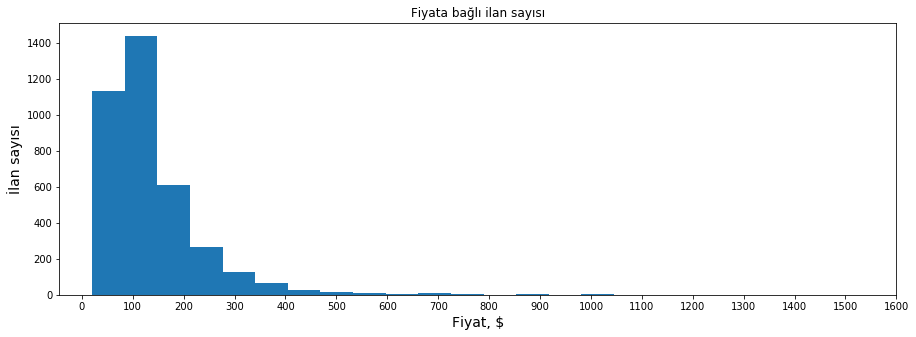

In [9]:
#ilan sayısının ortalama fiyat dağılım
ilan_icin_ortalama_fiyat = df.groupby('listing_id').mean()['price']

#plot
plt.figure(figsize=(15,5))
plt.hist(ilan_icin_ortalama_fiyat, bins=20)
plt.xticks(np.arange(0, 1700, step=100))
plt.ylabel('İlan sayısı',fontsize=14)
plt.xlabel('Fiyat, $',fontsize=14)
plt.title('Fiyata bağlı ilan sayısı')
plt.show()

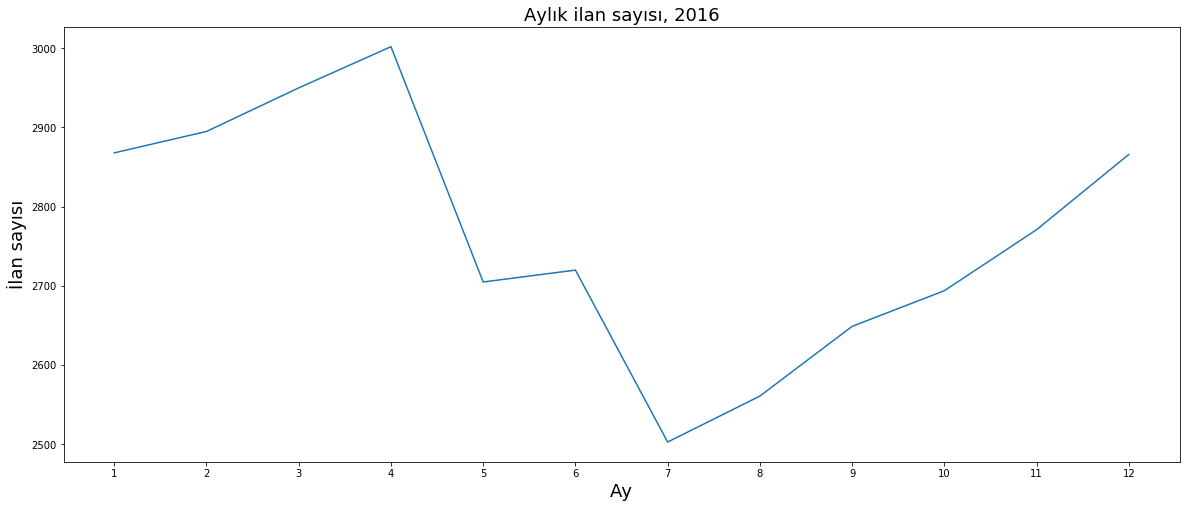

In [10]:
#2016 yılı aylık ilan sayısı
aylik_ilan_sayisi = pd.Series([12])
for i in range(1, 13):
    aylik_ilan_sayisi[i] = len(df[(df['month'] == i) & (df['year'] == 2016)]['listing_id'].unique())
    
aylik_ilan_sayisi = aylik_ilan_sayisi.drop(0)

#Grafik
plt.figure(figsize=(20,8))
plt.plot(aylik_ilan_sayisi)
plt.xticks(np.arange(1, 13, step=1))
plt.ylabel('İlan sayısı',fontsize=18)
plt.xlabel('Ay',fontsize=18)
plt.title('Aylık ilan sayısı, 2016',fontsize=18)
plt.show()

In [11]:
for col in df.columns: 
    print(col) 

listing_id
host_response_time
host_is_superhost
host_listings_count
host_has_profile_pic
host_identity_verified
neighbourhood_group_cleansed
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
guests_included
minimum_nights
maximum_nights
number_of_reviews
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
instant_bookable
cancellation_policy
require_guest_profile_picture
require_guest_phone_verification
calculated_host_listings_count
month
year
price
host_since_year
host_response_rate_buckets
host_verifications_email
host_verifications_ phone
host_verifications_ reviews
host_verifications_ facebook
host_verifications_ jumio
host_verifications_ kba
host_verifications_ linkedin
host_verifications_ google
host_verifications_ manual_offline
host_verifications_phone
amenities_Wireless Internet
amenities_Heating
amenities_Kitchen
amenities_Smoke Detector
amenitie

Text(0.5, 1.0, 'Aylik ilan sayısı,2016')

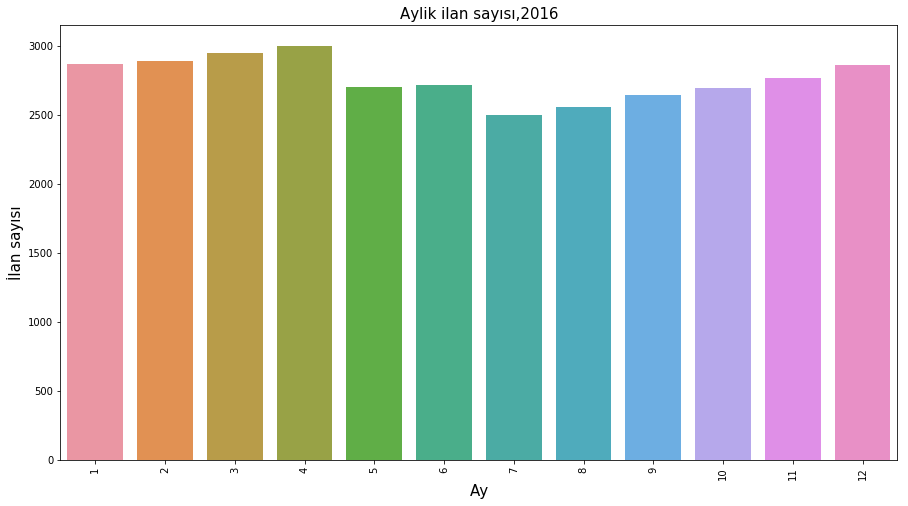

In [12]:
#İlan sayısının aylık dağılımının bar plot olarak gösterimi fazladan örnek
f, ax = plt.subplots(figsize=(15, 8))
plt.xticks(rotation='90')
sns.barplot(x=np.arange(1, 13, step=1), y=aylik_ilan_sayisi)
plt.xlabel('Ay', fontsize=15)
plt.ylabel('İlan sayısı', fontsize=15)
plt.title('Aylik ilan sayısı,2016', fontsize=15)

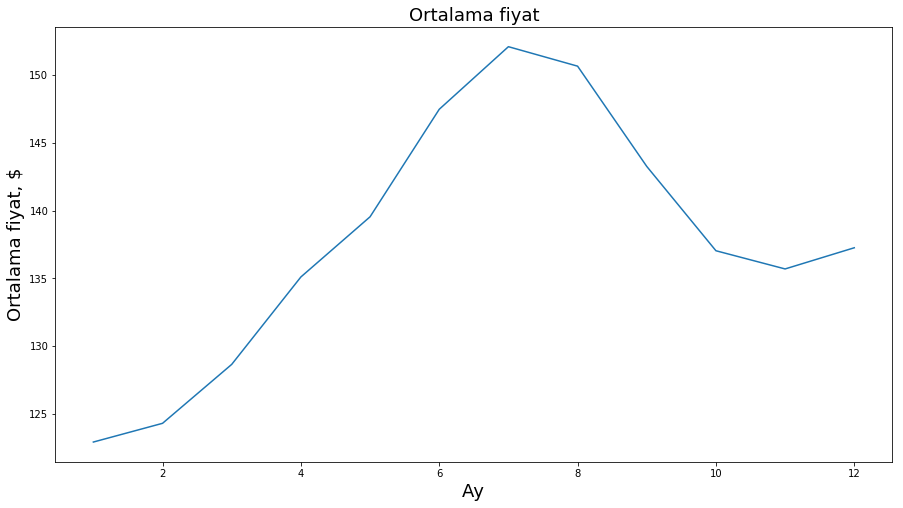

In [13]:
#aylık fiyat bulma
aylik_ortalama_fiyat = df.groupby(['month'])['price'].mean()

#Grafik
plt.figure(figsize=(15,8))
plt.plot(aylik_ortalama_fiyat)
plt.ylabel('Ortalama fiyat, $',fontsize=18)
plt.xlabel('Ay',fontsize=18)
plt.title('Ortalama fiyat',fontsize=18)
plt.show()

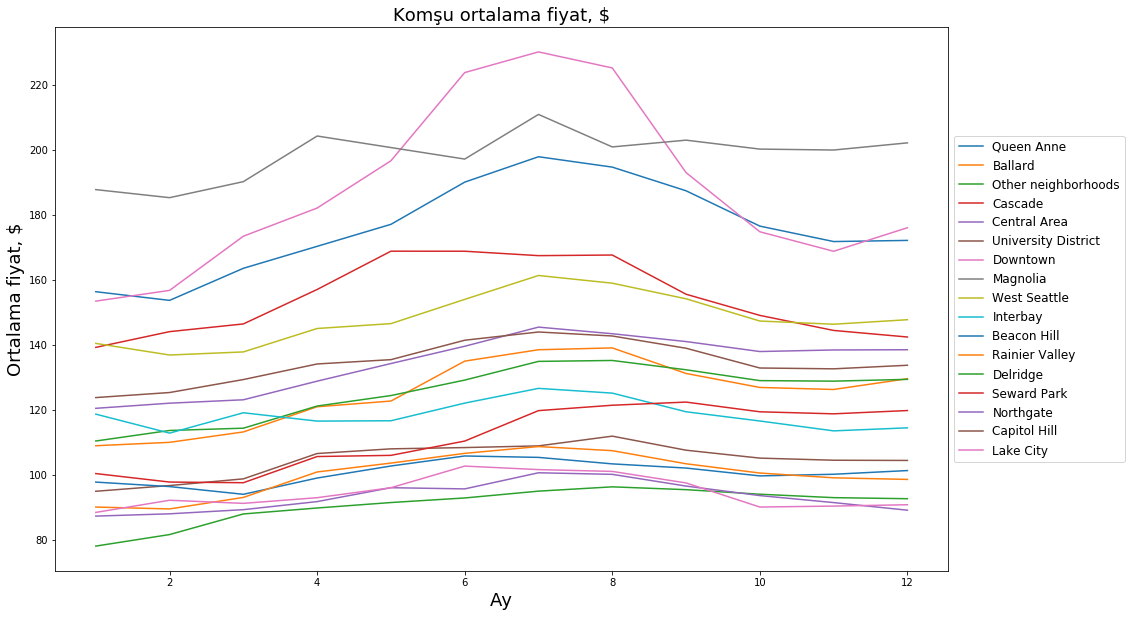

In [14]:
#komşu ilan sayılarının hesaplanması ve gösterimi
komsular = df['neighbourhood_group_cleansed'].unique()

#komşu aylık ortalama fiyat bilgisinin hesaplanması
komsu_aylik_ortalama_fiyat = df.groupby(['month','neighbourhood_group_cleansed']).mean().reset_index()

#her bir komşunun aylık ortalama fiyatının grafiği
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)

for komsu in komsular:
    ax.plot(komsu_aylik_ortalama_fiyat[komsu_aylik_ortalama_fiyat['neighbourhood_group_cleansed'] == komsu]['month'],
             komsu_aylik_ortalama_fiyat[komsu_aylik_ortalama_fiyat['neighbourhood_group_cleansed'] == komsu]['price'],
             label = komsu)
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)
plt.ylabel('Ortalama fiyat, $',fontsize=18)
plt.xlabel('Ay',fontsize=18)
plt.title('Komşu ortalama fiyat, $',fontsize=18)
plt.show()

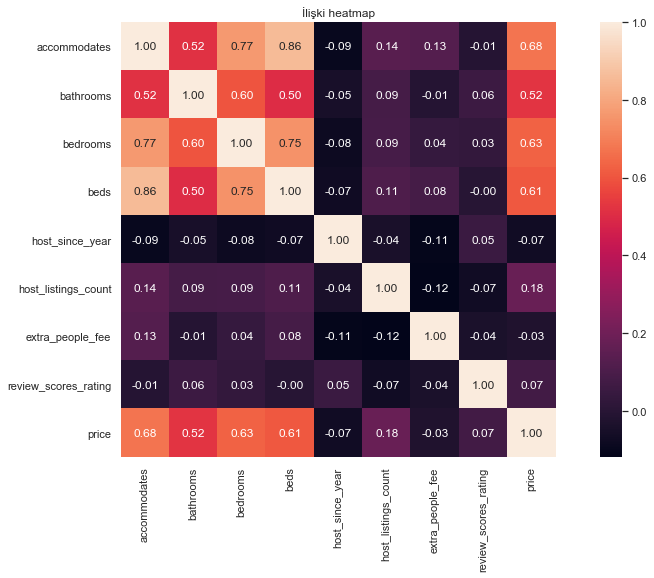

In [15]:
#Sütunlar arasındaki ilişkinin gösterimi heatmap ile
sutunlar = ['accommodates','bathrooms','bedrooms','beds','host_since_year',
        'host_listings_count', 'extra_people_fee',
        'review_scores_rating', 'price']

iliskiler = np.corrcoef(df[sutunlar].values.T)
sns.set(font_scale=2)
sns.set(rc={'figure.figsize':(16,8)})
hm=sns.heatmap(iliskiler, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = sutunlar, xticklabels = sutunlar).set_title('İlişki heatmap')
fig = hm.get_figure()

In [16]:
#categorical sütununu kukla değişkene dönüştürme
kategori_sutunu = list(df.select_dtypes(include=['object']).columns)
    
for sut in  kategori_sutunu:
    df = pd.concat([df.drop(sut, axis=1), pd.get_dummies(df[sut], prefix=sut, prefix_sep='_',

                                                         drop_first=True, dummy_na=True)], axis=1)
#listing_id ve year columns sütununu silme
df = df.drop(columns = ['listing_id', 'year'])

In [17]:
#veri setini eğitim ve test için model göre uyarlanması
TEST_BOYUTU = 0.3
RASTGELE_DURUM = 42

X = df.drop(columns = 'price')
y = df[['price']]

X_egitim, X_test, y_egitim, y_test = train_test_split(X, y, test_size = TEST_BOYUTU, random_state=RASTGELE_DURUM)

In [17]:
#Eğitim Random Forest Regressor Model
forest = RandomForestRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=RASTGELE_DURUM, 
                               n_jobs=-1)
forest.fit(X_egitim, y_egitim.squeeze())

#Sonuçların model için hesaplanması
y_egitim_tahmin = forest.predict(X_egitim)
y_test_tahmin = forest.predict(X_test)

print('Random Forest MSE eğitim: %.3f, test: %.3f' % (
        mean_squared_error(y_egitim, y_egitim_tahmin),
        mean_squared_error(y_test, y_test_tahmin)))
print('Random Forest R^2 eğitim: %.3f, test: %.3f' % (
        r2_score(y_egitim, y_egitim_tahmin),
        r2_score(y_test, y_test_tahmin)))

Random Forest MSE eğitim: 186.848, test: 211.114
Random Forest R^2 eğitim: 0.983, test: 0.981


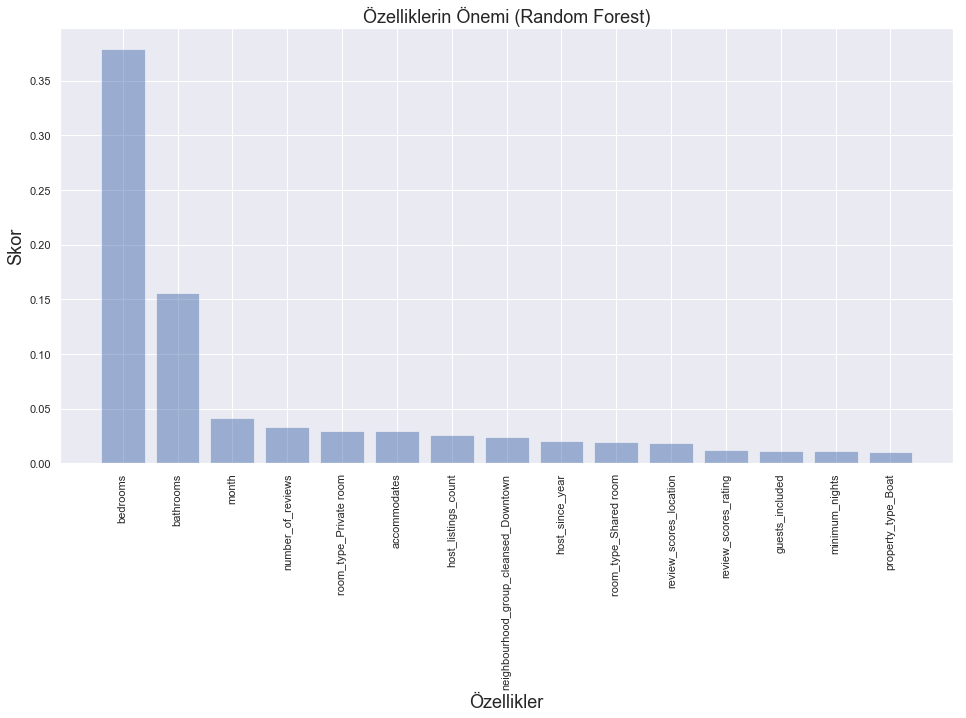

In [18]:
#Model için özelliklerin öneminin hesaplanması
basliklar = ["name", "score"]
degerler = sorted(zip(X_egitim.columns, forest.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(degerler, columns = basliklar)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:15]

#Özellik Önem Grafiği
plt.figure(figsize=(16,8))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Skor',fontsize=18)
plt.xlabel('Özellikler',fontsize=18)
plt.title('Özelliklerin Önemi (Random Forest)',fontsize=18)
plt.show()

In [29]:
X_egitim.groupby('bedrooms').count()

,host_listings_count,accommodates,bathrooms,beds,guests_included,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,...,bed_type_nan,instant_bookable_t,instant_bookable_nan,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_nan,require_guest_profile_picture_t,require_guest_profile_picture_nan,require_guest_phone_verification_t,require_guest_phone_verification_nan
bedrooms,,,,,,,,,,,,,,,,,,,,,
0.0,58844,58844,58844,58844,58844,58844,58844,58844,58844,58844,...,58844,58844,58844,58844,58844,58844,58844,58844,58844,58844
1.0,429534,429534,429534,429534,429534,429534,429534,429534,429534,429534,...,429534,429534,429534,429534,429534,429534,429534,429534,429534,429534
2.0,107626,107626,107626,107626,107626,107626,107626,107626,107626,107626,...,107626,107626,107626,107626,107626,107626,107626,107626,107626,107626
3.0,43911,43911,43911,43911,43911,43911,43911,43911,43911,43911,...,43911,43911,43911,43911,43911,43911,43911,43911,43911,43911
4.0,8725,8725,8725,8725,8725,8725,8725,8725,8725,8725,...,8725,8725,8725,8725,8725,8725,8725,8725,8725,8725
5.0,4271,4271,4271,4271,4271,4271,4271,4271,4271,4271,...,4271,4271,4271,4271,4271,4271,4271,4271,4271,4271
6.0,1058,1058,1058,1058,1058,1058,1058,1058,1058,1058,...,1058,1058,1058,1058,1058,1058,1058,1058,1058,1058
7.0,210,210,210,210,210,210,210,210,210,210,...,210,210,210,210,210,210,210,210,210,210


In [30]:
y_test

,price
515523,75.0
216540,75.0
374275,68.0
1290569,90.0
133258,88.0
419577,332.0
624706,75.0
821776,25.0
1382174,87.0
401685,91.0


In [18]:
#Eğitim XGBoost model
xgb = xgboost.XGBRegressor(n_estimators=500, learning_rate=0.04, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_egitim,y_egitim)

#15 özellik için skorların hesaplanması
y_egitim_tahmin = xgb.predict(X_egitim)
y_test_tahmin = xgb.predict(X_test)

print('MSE eğitim: %.3f, test: %.3f' % (
        mean_squared_error(y_egitim, y_egitim_tahmin),
        mean_squared_error(y_test, y_test_tahmin)))
print('R^2 eğitim: %.3f, test: %.3f' % (
        r2_score(y_egitim, y_egitim_tahmin),
        r2_score(y_test, y_test_tahmin)))

MSE eğitim: 509.979, test: 519.532
R^2 eğitim: 0.954, test: 0.952


In [23]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_egitim.values)
    rmse= np.sqrt(-cross_val_score(model, X_egitim.values, y_egitim, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [21]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
import xgboost as xgb
import lightgbm as lgb

In [25]:
model_xgb = xgb.XGBRegressor(colsample_bytree=1, gamma=0, 
                             learning_rate=0.04, max_depth=7, 
                             min_child_weight=1.7817, n_estimators=500,
                             subsample=0.75)

In [27]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 22.7262 (0.3440)



In [28]:
#Model için özelliklerin önemi 
basliklar = ["name", "score"]
degerler = sorted(zip(X_egitim.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(degerler, columns = basliklar)

#15 Özelliğin Önem Grafiği
features = xgb_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = xgb_feature_importances['score'][:15] 
plt.figure(figsize=(16,8))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Skor',fontsize=18)
plt.xlabel('Özellikler',fontsize=18)
plt.title('Özelliklerin Önemi (XGBoost)',fontsize=18) 
plt.show()

AttributeError: module 'xgboost' has no attribute 'feature_importances_'

# Machine Learning Fiyat Karşılaştırma

In [21]:
y_test.index.name = 'id'

In [22]:
y_test.head()

,price
id,
515523,75.0
216540,75.0
374275,68.0
1290569,90.0
133258,88.0


In [23]:
dfy_test_tahmin = pd.DataFrame(y_test_tahmin)
dfy_test_tahmin['price']=dfy_test_tahmin[0]

In [24]:
dfy_test_tahmin.reset_index(level=0, inplace=True)

In [25]:
dfy_test_tahmin.count()

index    280363
0        280363
price    280363
dtype: int64

In [29]:
y_test.reset_index(level=0, inplace=True)

In [30]:
y_test.head()

,id,price
0,515523,75.0
1,216540,75.0
2,374275,68.0
3,1290569,90.0
4,133258,88.0


In [31]:
dfy_test_tahmin['id'] = y_test['id']
dfy_test_tahmin.drop(0,axis=1,inplace=True)

In [32]:
dfy_test_tahmin.drop(['index'], axis=1, inplace=True)
dfy_test_tahmin.head()

,price,id
0,77.929924,515523
1,81.562607,216540
2,71.063301,374275
3,98.482933,1290569
4,103.607391,133258


In [33]:
y_test.max()

id       1393212.0
price       1650.0
dtype: float64

In [34]:
dfy_test_tahmin.max()

price    1.632086e+03
id       1.393212e+06
dtype: float64

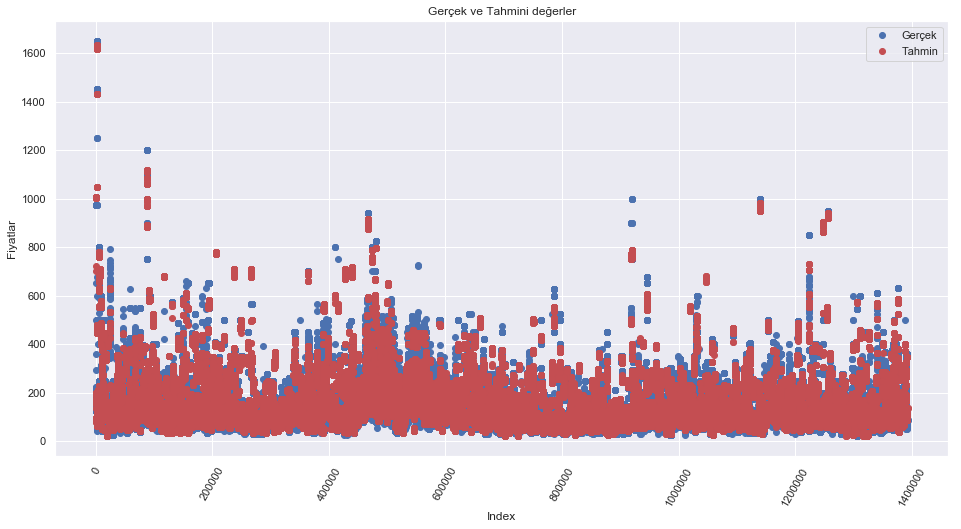

In [35]:
plt.figure(figsize=(16,8))
plt.plot(y_test['id'], y_test['price'], 'o', label = 'Gerçek')
plt.plot(dfy_test_tahmin['id'], dfy_test_tahmin['price'], 'ro', label = 'Tahmin')
plt.xticks(rotation = '60'); 
plt.legend()
plt.xlabel('Index'); plt.ylabel('Fiyatlar'); plt.title('Gerçek ve Tahmini değerler');

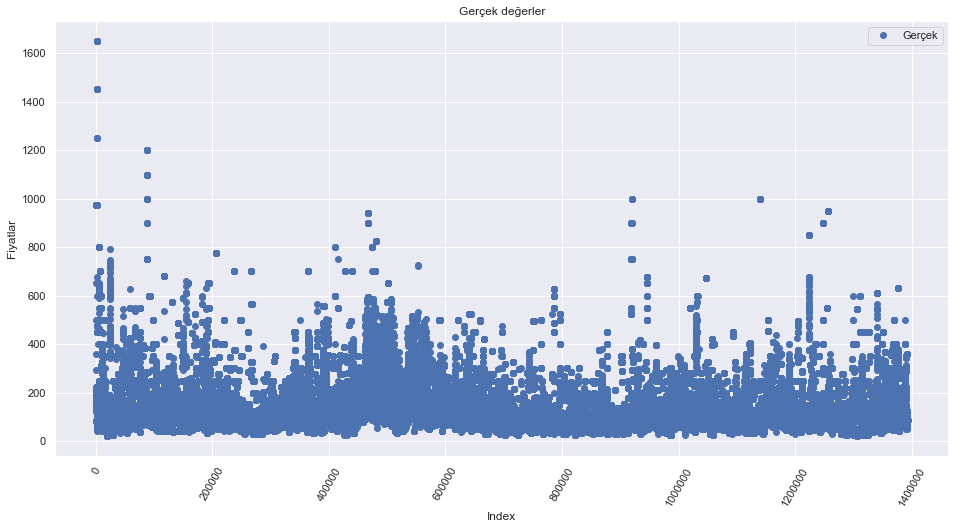

In [36]:
plt.figure(figsize=(16,8))
plt.plot(y_test['id'], y_test['price'], 'o', label = 'Gerçek')
plt.xticks(rotation = '60'); 
plt.legend()
plt.xlabel('Index'); plt.ylabel('Fiyatlar'); plt.title('Gerçek değerler');

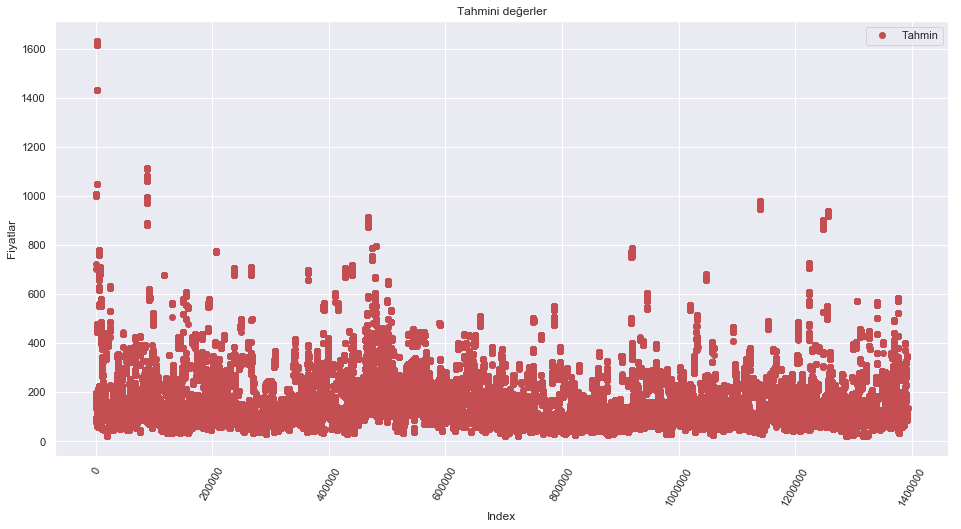

In [37]:
plt.figure(figsize=(16,8))
plt.plot(dfy_test_tahmin['id'], dfy_test_tahmin['price'], 'ro', label = 'Tahmin')
plt.xticks(rotation = '60'); 
plt.legend()
plt.xlabel('Index'); plt.ylabel('Fiyatlar'); plt.title('Tahmini değerler');

# Target Value Analysis

In [51]:
y_egitim["price"].describe()

count    654179.000000
mean        138.025498
std         105.395649
min          10.000000
25%          75.000000
50%         109.000000
75%         160.000000
max        1650.000000
Name: price, dtype: float64

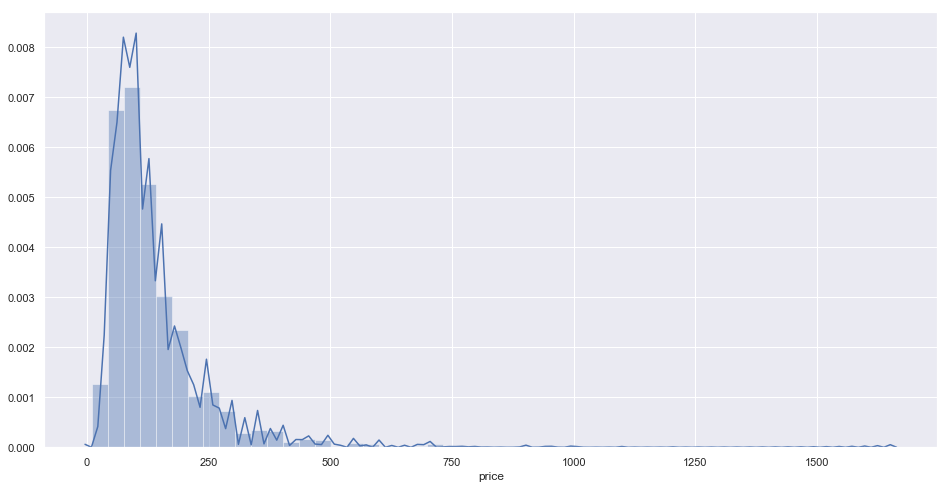

In [52]:
sns.distplot(y_egitim["price"]);

In [53]:
#skewness and kurtosis
print("Skewness: %f" % y_egitim["price"].skew())
print("Kurtosis: %f" % y_egitim["price"].kurt())

Skewness: 3.236567
Kurtosis: 18.410692


In [61]:
y.head()

,price
0,85.0
1,85.0
9,85.0
10,85.0
14,85.0



 mu = 138.03 and sigma = 105.40



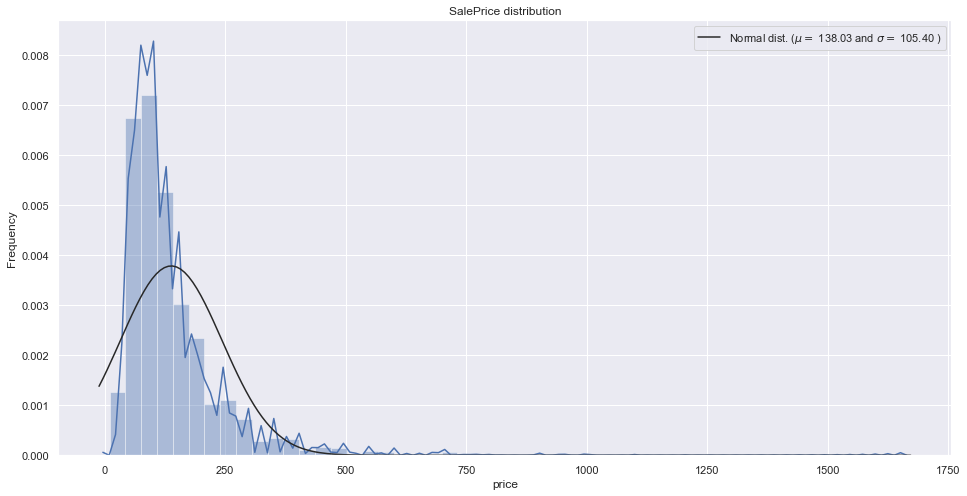

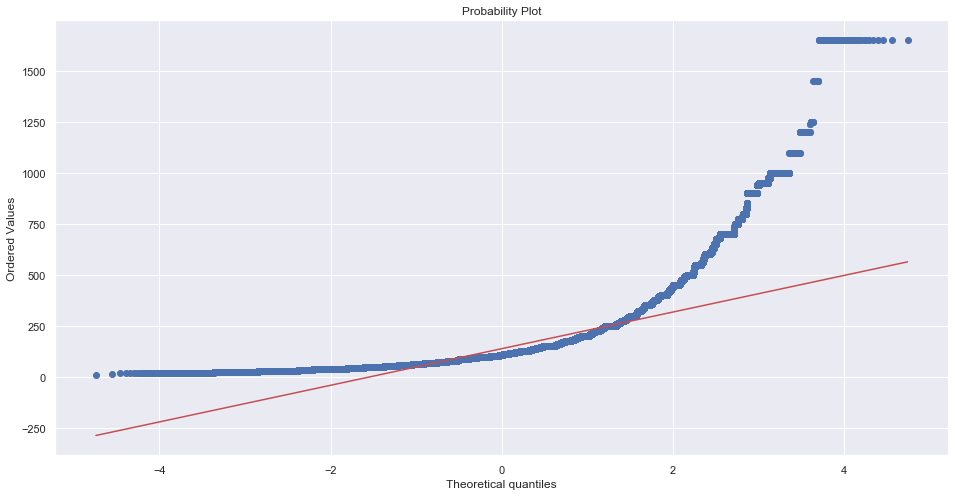

In [64]:
from scipy.stats import norm, skew #for some statistics
from scipy import stats
sns.distplot(y_egitim["price"], fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_egitim["price"])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_egitim["price"], plot=plt)
plt.show()

C:\Users\ENDERYILDIZ\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  



 mu = 4.74 and sigma = 0.59



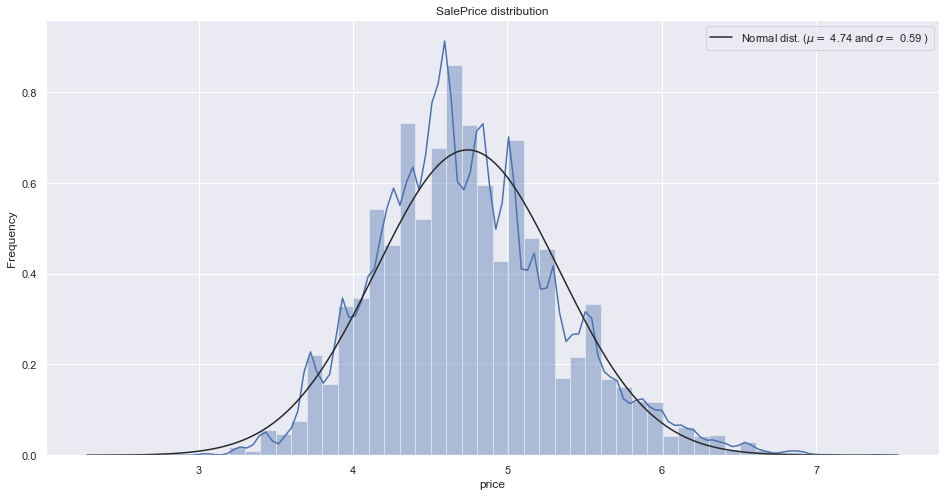

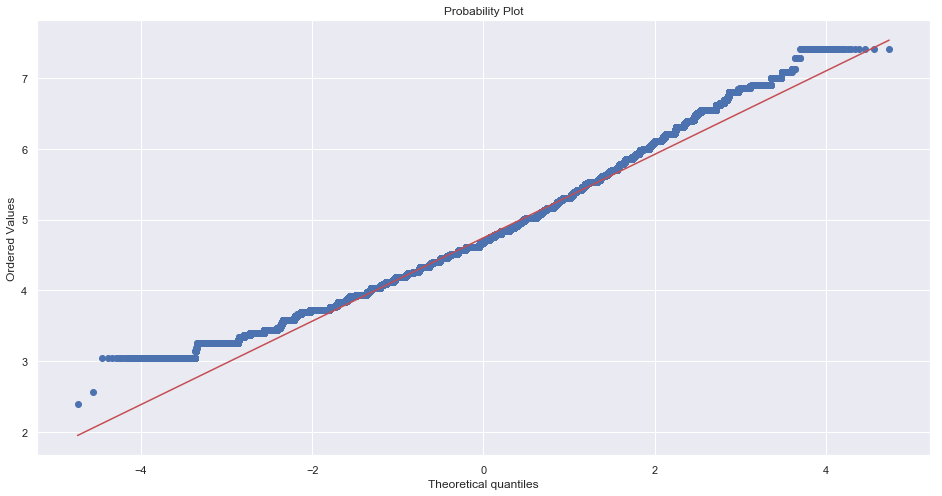

In [65]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
y_egitim["price"] = np.log1p(y_egitim["price"])

#Check the new distribution 
sns.distplot(y_egitim["price"] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_egitim["price"])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_egitim["price"], plot=plt)
plt.show()